In [420]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind

sns.set_style('white')

# Prediction

For investors it's interesting to know which characteristics of a loan are predictive of a loan ending in charged off. Lending club has its own algorithms beforehand that they use to predict which loans are riskier and give these a grade (A-F). This correlates well with the probability of charged off as we saw in the exploration of the dataset. The interest rates should reflect the risk (higher interest with more risk) to make the riskier loans still attractive to invest in. Although grade and interest correlates well, it's not a perfect correlation. 

We will here use the loans that went to full term to build classifiers that can classify loans into charged off and fully paid. The accuracy measure used is 'f1_weighted' of sklearn. This score can be interpreted as a weighted average of the precision and recall. Also confusion matrices and ROC curves will be used for analysis. Grade is used as baseline prediction for charged off/fully paid. We will look for features that add extra predictive value on top of the grade feature and see if this gives us any insight.

### Select loans and features
We selected the loans here that went to full term and add the characteristic whether they were charged off or not. We excluded the one loan that was a joint application. The number of loans left are 255,719. And the percentage of charged_off loans is 18%.

In [341]:
loans = pd.read_csv('../data/loan.csv')
closed_loans = loans[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]
print(closed_loans.shape)
round(sum(closed_loans['loan_status']=='Charged Off')/len(closed_loans['loan_status'])*100)

(252971, 74)


/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


18.0

### Select features
We selected features that can be included for the prediction. For this we left out features that are not known at the beginning, like 'total payment'. Because these are not useful features to help new investors. Also non-predictive features like 'id' or features that have all the same values are also excluded. All features to do with 'joint' loans are also excluded, since we do not have joint loans. We did add loan_status and charged_off for the prediction. Furthermore, features that were missing in more than 5% of the loans were excluded leaving 24 features (excluding the targets loan_status and charged_off). 

In [342]:
include = ['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 
          'annual_inc', 'purpose', 'zip_code', 'addr_state', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 
          'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
          'mths_since_last_major_derog', 'acc_now_delinq', 'loan_amnt', 'open_il_6m', 'open_il_12m', 
          'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'dti', 'open_acc_6m', 'tot_cur_bal',
          'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
          'inq_last_12m', 'issue_d', 'loan_status']

exclude = ['funded_amnt', 'funded_amnt_inv', 'verfication_status', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
           'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 
           'initial_list_status', 'id', 'member_id', 'emp_title', 'pymnt_plan', 'url', 'desc', 'title', 
           'out_prncp', 'out_prncp_inv', 'total_pymnt', 'last_pymnt_amnt', 'next_pymnt_d', 'policy_code', 
           'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt',
           ]


# exclude the one joint application
closed_loans = closed_loans[closed_loans['application_type'] == 'INDIVIDUAL']

# make id index
closed_loans.index = closed_loans.id

# include only the features above
closed_loans = closed_loans[include]

# exclude features with more than 5% missing values
columns_not_missing = (closed_loans.isnull().apply(sum, 0) / len(closed_loans)) < 0.1
closed_loans = closed_loans.loc[:,columns_not_missing[columns_not_missing].index]

# delete rows with NANs
print(1 - closed_loans.dropna().shape[0] / closed_loans.shape[0]) # ratio deleted rows
closed_loans = closed_loans.dropna()

# calculate nr of days between earliest creditline and issue date of the loan
# delete the two original features
closed_loans['earliest_cr_line'] = pd.to_datetime(closed_loans['earliest_cr_line'])
closed_loans['issue_d'] = pd.to_datetime(closed_loans['issue_d'])
closed_loans['days_since_first_credit_line'] = closed_loans['issue_d'] - closed_loans['earliest_cr_line']
closed_loans['days_since_first_credit_line'] = closed_loans['days_since_first_credit_line'] / np.timedelta64(1, 'D')
closed_loans = closed_loans.drop(['earliest_cr_line', 'issue_d'], axis=1)

# delete redundant features
#closed_loans = closed_loans.drop(['grade'], axis=1)

# round-up annual_inc and cut-off outliers annual_inc at 200.000
closed_loans['annual_inc'] = np.ceil(closed_loans['annual_inc'] / 1000)
closed_loans.loc[closed_loans['annual_inc'] > 200, 'annual_inc'] = 200

closed_loans.shape

0.0007866545440170514


(252771, 23)

In [343]:
closed_loans.head()

,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,purpose,zip_code,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,loan_amnt,dti,loan_status,days_since_first_credit_line
id,,,,,,,,,,,,,,,,,,,,,
1077501,36 months,10.65,162.87,B,B2,10+ years,RENT,24.0,credit_card,860xx,...,3.0,0.0,13648.0,83.7,9.0,0.0,5000.0,27.65,Fully Paid,9830.0
1077430,60 months,15.27,59.83,C,C4,< 1 year,RENT,30.0,car,309xx,...,3.0,0.0,1687.0,9.4,4.0,0.0,2500.0,1.00,Charged Off,4627.0
1077175,36 months,15.96,84.33,C,C5,10+ years,RENT,13.0,small_business,606xx,...,2.0,0.0,2956.0,98.5,10.0,0.0,2400.0,8.72,Fully Paid,3682.0
1076863,36 months,13.49,339.31,C,C1,10+ years,RENT,50.0,other,917xx,...,10.0,0.0,5598.0,21.0,37.0,0.0,10000.0,20.00,Fully Paid,5782.0
1075269,36 months,7.90,156.46,A,A4,3 years,RENT,36.0,wedding,852xx,...,9.0,0.0,7963.0,28.3,12.0,0.0,5000.0,11.20,Fully Paid,2586.0


In [229]:
closed_loans.columns

Index(['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'purpose', 'zip_code', 'addr_state',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'acc_now_delinq', 'loan_amnt', 'dti',
       'loan_status', 'days_since_first_credit_line'],
      dtype='object')

(array([  2.00000000e+00,   1.60000000e+01,   3.50000000e+01,
          1.80000000e+02,   3.33000000e+02,   3.36000000e+02,
          7.76000000e+02,   8.31000000e+02,   1.43700000e+03,
          1.42800000e+03,   2.16300000e+03,   3.31500000e+03,
          2.76100000e+03,   5.69800000e+03,   3.77600000e+03,
          3.77500000e+03,   7.98500000e+03,   4.74700000e+03,
          9.69400000e+03,   6.15900000e+03,   4.64200000e+03,
          9.43800000e+03,   6.27400000e+03,   1.11370000e+04,
          6.03300000e+03,   4.95100000e+03,   8.92800000e+03,
          4.74000000e+03,   1.15990000e+04,   4.05400000e+03,
          3.74300000e+03,   9.12000000e+03,   4.12500000e+03,
          1.26500000e+03,   8.25300000e+03,   4.72300000e+03,
          7.87700000e+03,   2.33300000e+03,   2.87100000e+03,
          7.41700000e+03,   2.74100000e+03,   6.07800000e+03,
          2.12800000e+03,   2.07000000e+03,   5.63600000e+03,
          2.29700000e+03,   3.54800000e+03,   2.03800000e+03,
        

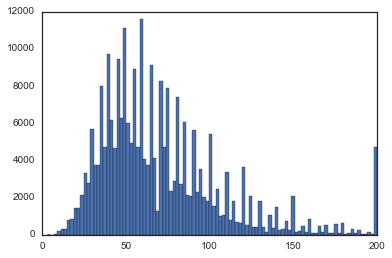

In [230]:
plt.hist(closed_loans['annual_inc'], bins=100)

### Split data
We keep 30% of the data separate for now so we can later use this to reliable test the performance of the classifier. The split is stratified by 'loan_status' in order to equally divide old loans over the split (old loans have a higher 'charged_off' probability). The classes to predict are in the variable 'charged_off'.

In [237]:
X_train, X_test, y_train, y_test = train_test_split(closed_loans, closed_loans['loan_status'], 
                                                    test_size=0.3, random_state=123)
X_train = X_train.drop('loan_status', axis=1)
X_test = X_test.drop('loan_status', axis=1)

### Logistic regression

We will first start with the logistic regression classifier. This is a simple classifier that uses a sigmoidal curve to predict from the features to which class the sample belongs. It has one parameter to tune namely the C-parameter. This is the inverse of the regularization strength, smaller values specify stronger regularization. In sklearn the features have to be numerical that we input in this algorithm, so we need to convert the categorical features to numeric. To do this ordered categorical features will have adjacent numbers and unordered features will get an order as best as possible during conversion to numeric, for instance geographical. Also there cannot be nan/inf/-inf values, hence these will be made 0's. With this algorithm we will also have to scale and normalize the features. 

Non-numeric features were converted as follows:
- earliest_cr_line: the date was converted to a timestamp number
- grade/sub_grade: order of the letters was kept
- emp_length: nr of years
- zipcode: numbers kept of zipcode (geographical order)
- term: in months
- home_ownership: from none to rent to mortgage to owned
- purpose: from purposes that might make money to purposes that only cost money
- addr_state: ordered geographically from west to east, top to bottom (https://theusa.nl/staten/)


In [239]:
# features that are not float or int, so not to be converted:

# ordered:
# sub_grade, emp_length, zip_code, term

# unordered:
# home_ownership, purpose, addr_state (ordered geographically)

# term
X_train['term'] = X_train['term'].apply(lambda x: int(x.split(' ')[1]))

# grade
loans['grade'] = loans['grade'].astype('category')
grade_dict = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
X_train['grade'] = X_train['grade'].apply(lambda x: grade_dict[x])

# emp_length
emp_length_dict = {'n/a':0,
                   '< 1 year':0,
                   '1 year':1,
                   '2 years':2,
                   '3 years':3,
                   '4 years':4,
                   '5 years':5,
                   '6 years':6,
                   '7 years':7,
                   '8 years':8,
                   '9 years':9,
                   '10+ years':10}
X_train['emp_length'] = X_train['emp_length'].apply(lambda x: emp_length_dict[x])

# zipcode
X_train['zip_code'] = X_train['zip_code'].apply(lambda x: int(x[0:3]))

# subgrade
X_train['sub_grade'] = X_train['grade'] + X_train['sub_grade'].apply(lambda x: float(list(x)[1])/10)

# house
house_dict = {'NONE': 0, 'OTHER': 0, 'ANY': 0, 'RENT': 1, 'MORTGAGE': 2, 'OWN': 3}
X_train['home_ownership'] = X_train['home_ownership'].apply(lambda x: house_dict[x])

# purpose
purpose_dict = {'other': 0, 'small_business': 1, 'renewable_energy': 2, 'home_improvement': 3,
                'house': 4, 'educational': 5, 'medical': 6, 'moving': 7, 'car': 8, 
                'major_purchase': 9, 'wedding': 10, 'vacation': 11, 'credit_card': 12, 
                'debt_consolidation': 13}
X_train['purpose'] = X_train['purpose'].apply(lambda x: purpose_dict[x])

# states
state_dict = {'AK': 0, 'WA': 1, 'ID': 2, 'MT': 3, 'ND': 4, 'MN': 5, 
              'OR': 6, 'WY': 7, 'SD': 8, 'WI': 9, 'MI': 10, 'NY': 11, 
              'VT': 12, 'NH': 13, 'MA': 14, 'CT': 15, 'RI': 16, 'ME': 17,
              'CA': 18, 'NV': 19, 'UT': 20, 'CO': 21, 'NE': 22, 'IA': 23, 
              'KS': 24, 'MO': 25, 'IL': 26, 'IN': 27, 'OH': 28, 'PA': 29, 
              'NJ': 30, 'KY': 31, 'WV': 32, 'VA': 33, 'DC': 34, 'MD': 35, 
              'DE': 36, 'AZ': 37, 'NM': 38, 'OK': 39, 'AR': 40, 'TN': 41, 
              'NC': 42, 'TX': 43, 'LA': 44, 'MS': 45, 'AL': 46, 'GA': 47, 
              'SC': 48, 'FL': 49, 'HI': 50}
X_train['addr_state'] = X_train['addr_state'].apply(lambda x: state_dict[x])

# make NA's, inf and -inf 0
X_train = X_train.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)

In [240]:
X_train.columns

Index(['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'purpose', 'zip_code', 'addr_state',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'acc_now_delinq', 'loan_amnt', 'dti',
       'days_since_first_credit_line'],
      dtype='object')

In [241]:
# scaling and normalizing the features
X_train_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

After the categorical features are conversed to numeric an normalized/scaled, we will first check what the accuracy is when only using the feature 'grade' (A-F) to predict 'charged off' (True/False). This is the classification lending club gave the loans. The closer to F the higher the chance the loan will end in 'charged off'. For the accuracy estimation we will use 'F1-weighted'. This stands for F1 = 2 * (precision * recall) / (precision + recall). In this way both precision and recall is important for the accuracy. Precision is the number of correct positive results divided by the number of all positive results, and recall is the number of correct positive results divided by the number of positive results that should have been returned. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0. In this case using only 'grade' as feature, using the default parameter value for C (inverse of regularization strength) and using l1/lasso penalization we get an F1-accuracy of 0.744.

In [242]:
clf = LogisticRegression(penalty='l1')
scores = cross_val_score(clf, X_train_scaled.loc[:,['grade']], y_train, cv=10, scoring='f1_weighted')
print(scores)
print(np.mean(scores))

[ 0.7451726   0.74695486  0.74425513  0.7456573   0.74568727  0.7450578
  0.74423565  0.74611306  0.74540367  0.74482549]
0.745336282371


A score of 0.744 looks not really high but still a lot better than random. Nevertheless, if we look into the confusion matrix and the ROC-curve we see a whole other picture. It turns out the algorithm mostly predicts everything in the not charged off group and therefore gets the majority right, because there are a lot more paid loans than charged off loans (18%). The area under the curve even gives only a score of 0.506 while random is 0.5. The prediction with logistic regression and only feature grade is therefore only as good as random.

Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off          117       14057    14174
Fully Paid           487       61295    61782
__all__              604       75352    75956


Overall Statistics:

Accuracy: 0.808520722524
95% CI: (0.80570421101228251, 0.81131364877443635)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.000589413953434
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                Charged Off   Fully Paid
Population                                   75956        75956
P: Condition positive                        14174        61782
N: Condition negative                        61782        14174
Test outcome positive                          604        75352
Test outcome negative                        75352          604
TP: True Positive                              117        61295
TN: True Negative                            61295          117
FP: False Posi

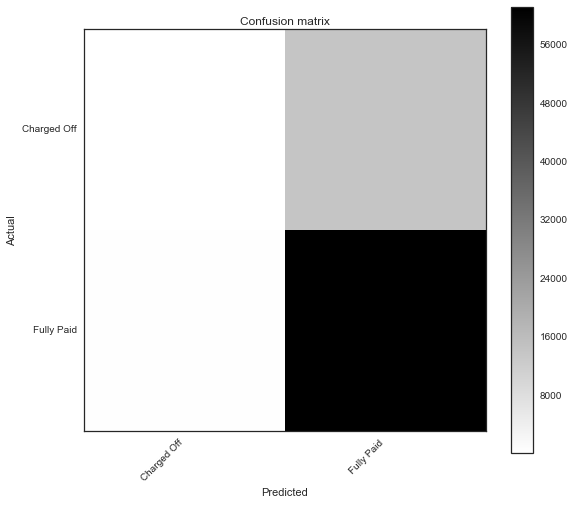

In [243]:
from sklearn.model_selection import cross_val_predict
from pandas_confusion import ConfusionMatrix

prediction = cross_val_predict(clf, X_train_scaled.loc[:,['grade']], y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

0.662577306672


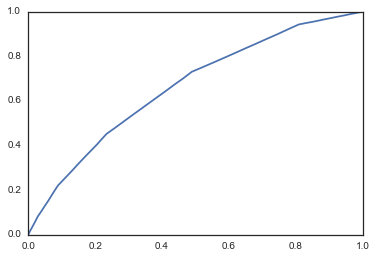

In [251]:
y_score = cross_val_predict(clf, X_train_scaled.loc[:,['grade']], y_train, cv=10, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_score[:,0], pos_label='Charged Off')
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

We can now include all the features we selected (24) and see if the prediction will be better. Because we use regularization, the effect of not useful features will be downgraded automatically. This leads to a slightly better F1-score of 0.751. Also the confusion matrix and the ROC-curve/AUC-score are a little better. Although still not great with an AUC score of 0.515. The top-5 features most used by the algorithm are: 'funded_amnt_inv', 'int_rate', 'sub_grade', 'funded_amnt' and 'annual_inc'. Not even grade itself.

In [256]:
clf = LogisticRegression(penalty='l1')
scores = cross_val_score(clf, X_train_scaled, y_train, cv=10, scoring='f1_weighted')
print(scores)  
print(np.mean(scores))

[ 0.75310091  0.75227635  0.75317398  0.75325794  0.75425814  0.75201058
  0.75253293  0.7538835   0.75249689  0.75422849]
0.75312197205


Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off          195       13979    14174
Fully Paid           865       60917    61782
__all__             1060       74896    75956


Overall Statistics:

Accuracy: 0.80457106746
95% CI: (0.80173290951382237, 0.80738594264111385)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: -0.000378008425893
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                Charged Off   Fully Paid
Population                                   75956        75956
P: Condition positive                        14174        61782
N: Condition negative                        61782        14174
Test outcome positive                         1060        74896
Test outcome negative                        74896         1060
TP: True Positive                              195        60917
TN: True Negative                            60917          195
FP: False Posi

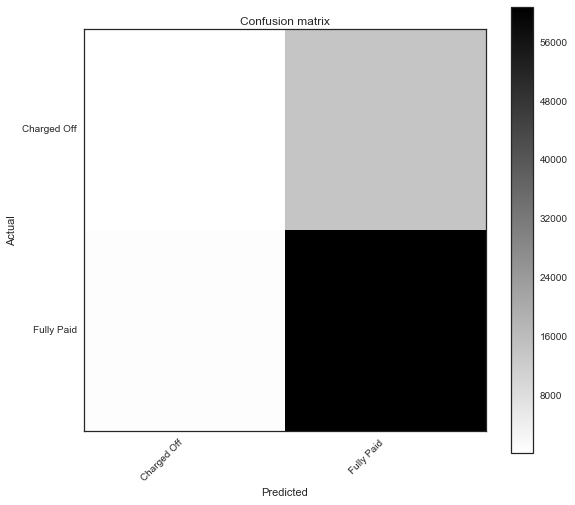

In [257]:
prediction = cross_val_predict(clf, X_train_scaled, y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

0.700731760785


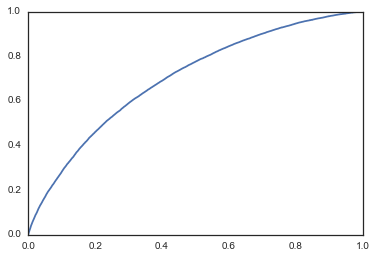

In [258]:
y_score = cross_val_predict(clf, X_train_scaled, y_train, cv=10, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_score[:,0], pos_label='Charged Off')
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

In [281]:
clf = LogisticRegression(penalty='l1', C=10)
clf.fit(X_train_scaled, y_train)
coefs = clf.coef_

# find index of top 5 highest coefficients, aka most used features for prediction
positions = abs(coefs[0]).argsort()[-5:][::-1]
print(X_train_scaled.columns[positions])
print(coefs[0][positions])

Index(['int_rate', 'annual_inc', 'sub_grade', 'term', 'dti'], dtype='object')
[-0.6129477   0.29842243  0.27762066 -0.17339293 -0.15911763]


We can also pick only 5 features and see if this works better. But it works exactly the same as only grade. So SelectKBest does not work as well with 5 features as using all features.

In [260]:
new_X = (SelectKBest(mutual_info_classif, k=5)
        .fit_transform(X_train_scaled, y_train))

In [262]:
print(new_X[0]) # term, int_rate, installement, grade, sub_grade
print(X_train_scaled.head())
new_X = pd.DataFrame(new_X, columns=['term', 'int_rate', 'installment', 'grade', 'sub_grade'])

[-0.53469047 -0.40174267  1.00571969 -0.59548115 -0.60103177]
       term  int_rate  installment     grade  sub_grade  emp_length  \
0 -0.534690 -0.401743     1.005720 -0.595481  -0.601032   -1.503256   
1  1.870241  0.865487     0.347860  0.900654   0.988284   -1.503256   
2 -0.534690 -0.092884    -0.352335  0.152587   0.080104    0.643787   
3  1.870241  0.554357    -0.710339  0.152587   0.231467   -1.503256   
4 -0.534690  0.863216    -0.427319  0.900654   0.761239   -0.698114   

   home_ownership  annual_inc   purpose  zip_code  \
0       -1.055764    0.437807  0.538410  1.171976   
1        0.528760    0.519080  0.538410 -0.778588   
2       -1.055764    0.681624  0.288887 -0.894062   
3       -1.055764   -0.781278  0.288887 -1.324746   
4       -1.055764   -0.510370  0.538410  1.171976   

               ...               inq_last_6mths  open_acc   pub_rec  \
0              ...                    -0.800122  1.851360 -0.329101   
1              ...                    -0.800122  1

In [263]:
clf = LogisticRegression(penalty='l1')
scores = cross_val_score(clf, new_X, y_train, cv=10, scoring='f1_weighted')
print(scores)  
print(np.mean(scores))

[ 0.74394672  0.74516986  0.74421423  0.74415496  0.74578639  0.74602528
  0.74268573  0.74441964  0.74488518  0.74455516]
0.744584314293


Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off           93       14081    14174
Fully Paid           429       61353    61782
__all__              522       75434    75956


Overall Statistics:

Accuracy: 0.808968350097
95% CI: (0.80615432037334445, 0.81175876027606175)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: -0.000608142860769
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                Charged Off   Fully Paid
Population                                   75956        75956
P: Condition positive                        14174        61782
N: Condition negative                        61782        14174
Test outcome positive                          522        75434
Test outcome negative                        75434          522
TP: True Positive                               93        61353
TN: True Negative                            61353           93
FP: False Pos

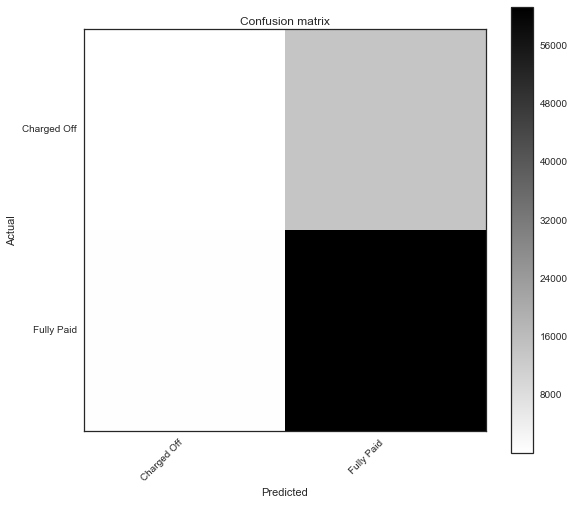

In [264]:
prediction = cross_val_predict(clf, new_X, y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

0.679367278898


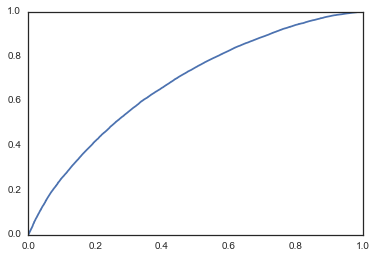

In [269]:
y_score = cross_val_predict(clf, new_X, y_train, cv=10, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_score[:,0], pos_label='Charged Off')
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

To see the statistical relevance of certain features, we can use the statsmodels package. We first use it with the 5 features selected by SelectKBest. We see there that only term, int_rate and installement are relevant. Confidence interval of all is small, but the coefficients of alle are also very close to 0, so do not seem to have a huge influence.

Subsequently we do the same for the 5 features with the highest coefficients in the regularized logistic regression that uses all features. Of these all features seem useful, except for 'sub_grade'. The coefficients are slightly higher and confidence intervals are small. Although the conclusions are contradictory. Funded_amnt and funded_amnt_inv have the highest coefficients. These two values should be roughly the same, but have a contradictory relation with the target value charged_off. This makes no sense and gives the idea that the algorithm is still pretty random.

In [274]:
y_train == 'Charged Off'

455306    False
790918    False
354831     True
76630     False
91839      True
130302    False
141508    False
225891    False
125360    False
424340     True
189953    False
425536    False
397052    False
150002    False
456947    False
201937     True
20655     False
82353     False
15805     False
179553     True
203884    False
54652     False
14433      True
186397    False
215405     True
393572    False
155273     True
11953      True
31773     False
24921     False
          ...  
135750    False
200590    False
217457    False
539140    False
394080    False
37762     False
220456    False
696143    False
384529     True
883627    False
264591    False
113698    False
188324    False
870075     True
226221    False
351325    False
102705     True
225235    False
450122     True
61789     False
199408    False
406847    False
217931    False
376823    False
189476    False
370936    False
19669     False
30115     False
17428     False
866544    False
Name: Actual, dtype: boo

In [275]:
import statsmodels.api as sm

print(new_X.columns)
logit = sm.Logit(y_train == 'Charged Off', np.array(new_X))
result = logit.fit()
print(result.summary())

Index(['term', 'int_rate', 'installment', 'grade', 'sub_grade'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.675398
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Actual   No. Observations:               176939
Model:                          Logit   Df Residuals:                   176934
Method:                           MLE   Df Model:                            4
Date:                Thu, 26 Jan 2017   Pseudo R-squ.:                 -0.4376
Time:                        18:22:55   Log-Likelihood:            -1.1950e+05
converged:                       True   LL-Null:                       -83125.
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0903      

In [277]:
logit = sm.Logit(y_train == 'Charged Off', np.array(
        X_train_scaled.loc[:,['int_rate', 'annual_inc', 'sub_grade', 'term', 'dti']]))
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.672390
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Actual   No. Observations:               176939
Model:                          Logit   Df Residuals:                   176934
Method:                           MLE   Df Model:                            4
Date:                Thu, 26 Jan 2017   Pseudo R-squ.:                 -0.4312
Time:                        18:24:22   Log-Likelihood:            -1.1897e+05
converged:                       True   LL-Null:                       -83125.
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.3304      0.019     17.575      0.000         0.294     0.367
x2            -0.1166      0.

Another way to possibly increase performance is to tune the C (penalization) parameter. We will do this with the GridSearchCV function of sklearn. The best performing C parameter, although really close with the default, is C=1. Giving an accuracy of 0.752. (code is quoted out because it takes a long time to run)

In [278]:
from sklearn.model_selection import GridSearchCV
dict_Cs = {'C': [0.001, 0.1, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(penalty='l1'), dict_Cs, 'f1_weighted', cv=10)

clf.fit(X_train_scaled, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'C': 10}
0.753161919566


In [280]:
clf = LogisticRegression(penalty='l1', C=10)
scores = cross_val_score(clf, X_train_scaled, y_train, cv=10, scoring='f1_weighted')
print(scores)  
print(np.mean(scores))

[ 0.75322471  0.75227635  0.75326607  0.75338166  0.75425814  0.75210257
  0.75256493  0.7538835   0.75243284  0.75422849]
0.753161926239


Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off          196       13978    14174
Fully Paid           868       60914    61782
__all__             1064       74892    75956


Overall Statistics:

Accuracy: 0.804544736426
95% CI: (0.80170643567460653, 0.80735975642941682)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: -0.000343773069975
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                Charged Off   Fully Paid
Population                                   75956        75956
P: Condition positive                        14174        61782
N: Condition negative                        61782        14174
Test outcome positive                         1064        74892
Test outcome negative                        74892         1064
TP: True Positive                              196        60914
TN: True Negative                            60914          196
FP: False Pos

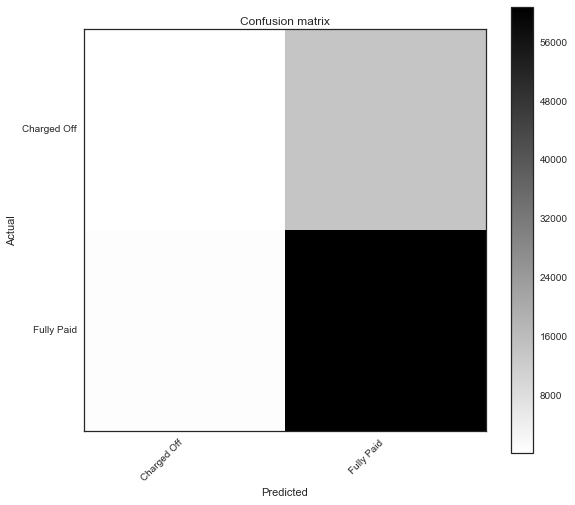

In [282]:
prediction = cross_val_predict(clf, X_train_scaled, y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

0.700731748611


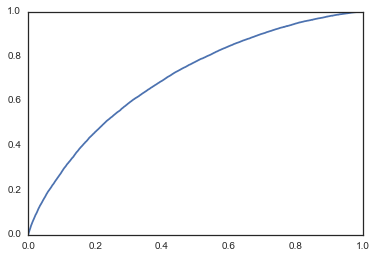

In [283]:
y_score = cross_val_predict(clf, X_train_scaled, y_train, cv=10, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_score[:,0], pos_label='Charged Off')
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

### Random Forest

To improve accuracy levels we could use a more complicated algorithm that scores well in a lot of cases, namely random forest. This algorithm makes various decision trees from subsets of the samples and uses at each split only a fraction of the features to prevent overfitting. The random forest algorithm is known to be not very sensitive to the values of its parameters: the number of features used at each split and the number of trees in the forest. Nevertheless, the default of sklearn is so low that we will raise the number of trees to 100. The algorithm has feature selection already builtin (at each split) and scaling/normalization is also not necessary. 

We will first run the algorithm with only grade. This makes not that much sense for Random Forest, since it builds trees. And you cannot build a tree from only one feature. Nevertheless, this will be our starting point. The F1 score is 0.739 hence slightly lower than logistic regression. As expected is the confusion matrix dramatic, namely the algorithm turns out to just predict everything as fully paid. And that's why the AUC-score is exactly random. 

In [284]:
clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, X_train.loc[:,['grade']], y_train, cv=10, scoring='f1_weighted')
print(scores)
print(np.mean(scores))

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/r

[ 0.74032961  0.74032961  0.74032961  0.74039443  0.74039443  0.74039443
  0.7403803   0.7403803   0.7403803   0.7403803 ]
0.740369331874


Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off            0       14174    14174
Fully Paid             0       61782    61782
__all__                0       75956    75956


Overall Statistics:

Accuracy: 0.813391963768
95% CI: (0.81060277776800005, 0.81615719138182941)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                               Charged Off Fully Paid
Population                                  75956      75956
P: Condition positive                       14174      61782
N: Condition negative                       61782      14174
Test outcome positive                           0      75956
Test outcome negative                       75956          0
TP: True Positive                               0      61782
TN: True Negative                           61782          0
FP: False Positive                              0   

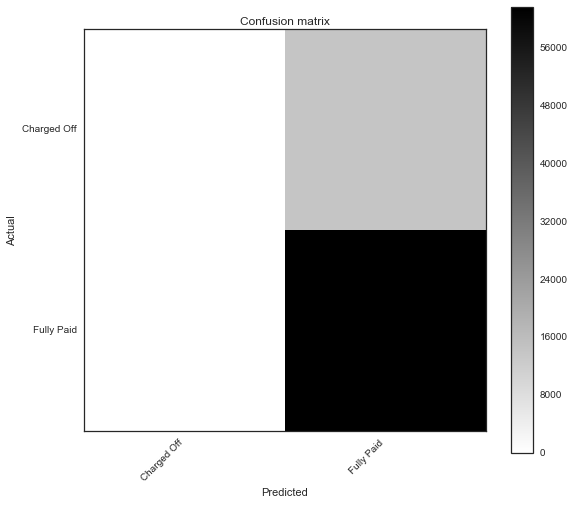

In [285]:
prediction = cross_val_predict(clf, X_train.loc[:,['grade']], y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

0.662009408724


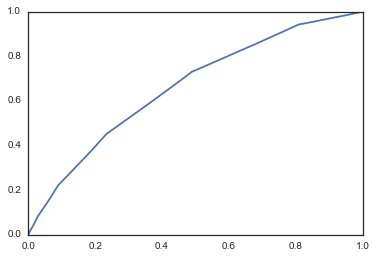

In [287]:
y_score = cross_val_predict(clf, X_train.loc[:,['grade']], y_train, cv=10, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_score[:,0], pos_label='Charged Off')
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

Trying the algorithm with all the features (24) leads to a slightly higher F1-score of 0.750. But logistic regression with all features was a fraction better than that. Also the confusion matrix and AUC is comparable but slightly worse than the logistic regression algorithm with all features. The random forest classifier does select a different top-5 features, namely 'dti', 'revol_bal', 'revol_util', 'annual_inc' and 'int_rate'. 

In [288]:
clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_weighted')
print(scores)
print(np.mean(scores))

[ 0.75355795  0.75200913  0.75151802  0.75171457  0.75187135  0.75392217
  0.75215301  0.75356562  0.75276674  0.75134994]
0.752442849609


Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off          224       13950    14174
Fully Paid           892       60890    61782
__all__             1116       74840    75956


Overall Statistics:

Accuracy: 0.804597398494
95% CI: (0.80175938337294439, 0.80741212883302516)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.00211724762002
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                               Charged Off  Fully Paid
Population                                  75956       75956
P: Condition positive                       14174       61782
N: Condition negative                       61782       14174
Test outcome positive                        1116       74840
Test outcome negative                       74840        1116
TP: True Positive                             224       60890
TN: True Negative                           60890         224
FP: False Positive             

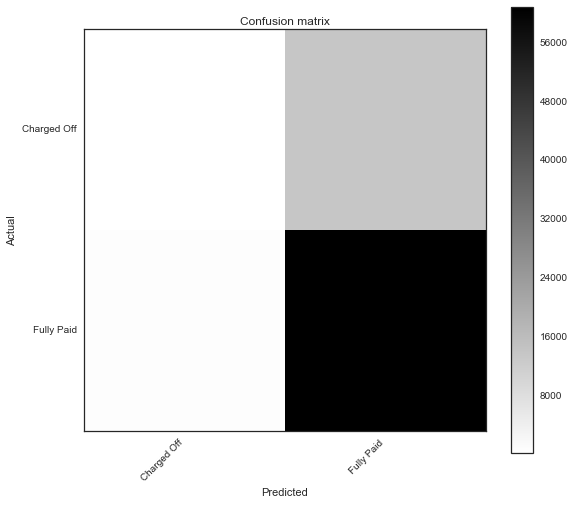

In [289]:
prediction = cross_val_predict(clf, X_train, y_train, cv=10)
confusion_matrix = ConfusionMatrix(y_train, prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

0.693645782868


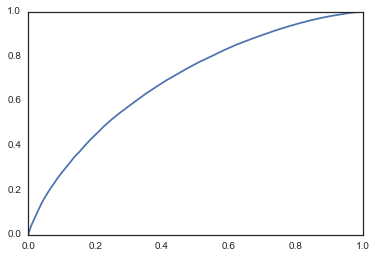

In [290]:
y_score = cross_val_predict(clf, X_train, y_train, cv=10, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_score[:,0], pos_label='Charged Off')
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

In [291]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
feat_imp = clf.feature_importances_

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

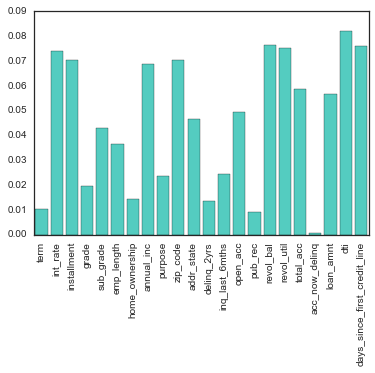

In [292]:
sns.barplot(x=X_train.columns, y=feat_imp, color='turquoise')
plt.xticks(rotation=90)

In [293]:
positions = abs(feat_imp).argsort()[-5:][::-1]
print(X_train.columns[positions])
print(feat_imp[positions])

Index(['dti', 'revol_bal', 'days_since_first_credit_line', 'revol_util',
       'int_rate'],
      dtype='object')
[ 0.08211771  0.07660079  0.07606937  0.07533684  0.07394158]


### Test set
To test the accuracies of our algorithms we first have to do the same transformations on the test set as we did on the training set. So we will transform the categorical features to numerical and replace nan/inf/-inf with 0. Also for the logistic regression algorithm we normalized and scaled the training set and we saved these transformations, so we can do the exact same tranformation on the test set.

In [294]:
# term
X_test['term'] = X_test['term'].apply(lambda x: int(x.split(' ')[1]))

# grade
X_test['grade'] = X_test['grade'].apply(lambda x: grade_dict[x])

# emp_length
X_test['emp_length'] = X_test['emp_length'].apply(lambda x: emp_length_dict[x])

# zipcode
X_test['zip_code'] = X_test['zip_code'].apply(lambda x: int(x[0:3]))

# subgrade
X_test['sub_grade'] = X_test['grade'] + X_test['sub_grade'].apply(lambda x: float(list(x)[1])/10)

# house
X_test['home_ownership'] = X_test['home_ownership'].apply(lambda x: house_dict[x])

# purpose
X_test['purpose'] = X_test['purpose'].apply(lambda x: purpose_dict[x])

# states
X_test['addr_state'] = X_test['addr_state'].apply(lambda x: state_dict[x])

# make NA's, inf and -inf 0
X_test = X_test.fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0)

In [295]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#### logistic regression

For logistic regression we will test both the 'only grade' algorithm (baseline) and the best performing algorithm (C=1, all features with regularization). We find practically the same F-scores/confusion matrices/ROC-curves/AUC-scores as for the training set. Therefore the crossvalidation scheme used on the training set gives reliable accuracy measurements. But it's clear that the predictive value of the algorithm increases slightly with more features, but it's basically predicting that all loans get fully paid and therefore the accuracy scores are practically random. 

0.746041404442
Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off           19        2529     2548
Fully Paid           101       13201    13302
__all__              120       15730    15850


Overall Statistics:

Accuracy: 0.834069400631
95% CI: (0.82818508469201324, 0.83983084214263837)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: -0.000221228958055
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                Charged Off   Fully Paid
Population                                   15850        15850
P: Condition positive                         2548        13302
N: Condition negative                        13302         2548
Test outcome positive                          120        15730
Test outcome negative                        15730          120
TP: True Positive                               19        13201
TN: True Negative                            13201           1

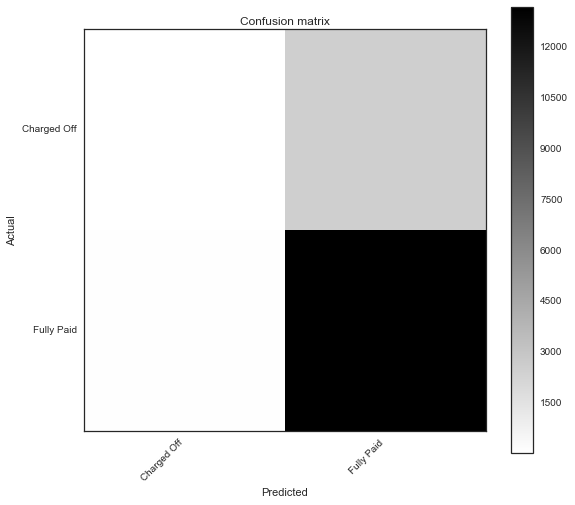

In [296]:
from sklearn.metrics import f1_score

clf = LogisticRegression(penalty='l1', C=10)
clf.fit(X_train_scaled.loc[:,['grade']], y_train)
prediction = clf.predict(X_test_scaled.loc[:,['grade']])
print(f1_score(y_test, prediction, average='weighted'))
confusion_matrix = ConfusionMatrix(y_test, prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

['Charged Off' 'Fully Paid']
0.662318128932


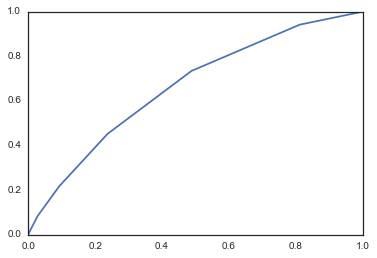

In [297]:
y_score = clf.predict_proba(X_test_scaled.loc[:,['grade']])
print(clf.classes_)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,0], pos_label='Charged Off')
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

0.753664722402
Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off           37        2511     2548
Fully Paid           202       13100    13302
__all__              239       15611    15850


Overall Statistics:

Accuracy: 0.828832807571
95% CI: (0.82287728997885279, 0.83466738743382574)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: -0.00104860773136
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                Charged Off   Fully Paid
Population                                   15850        15850
P: Condition positive                         2548        13302
N: Condition negative                        13302         2548
Test outcome positive                          239        15611
Test outcome negative                        15611          239
TP: True Positive                               37        13100
TN: True Negative                            13100           37

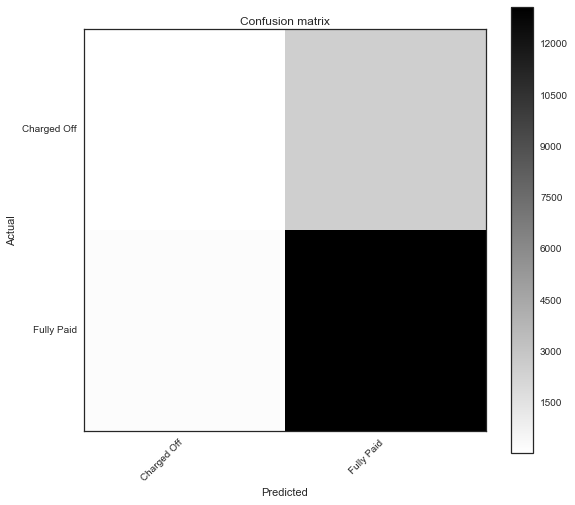

In [298]:
clf = LogisticRegression(penalty='l1', C=10)
clf.fit(X_train_scaled, y_train)
prediction = clf.predict(X_test_scaled)
print(f1_score(y_test, prediction, average='weighted'))
confusion_matrix = ConfusionMatrix(y_test, prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

['Charged Off' 'Fully Paid']
0.705200306527


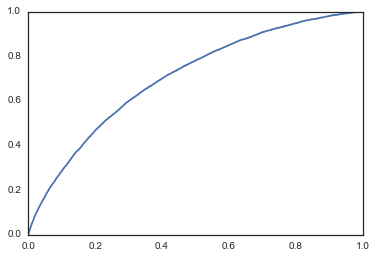

In [299]:
y_score = clf.predict_proba(X_test_scaled)
print(clf.classes_)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,0], pos_label='Charged Off')
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

# Try to see if top 25% and bottom 25% are ok (or 10%). Can we at least avoid bad loans?

In [344]:
closed_loans2 = closed_loans.drop(['loan_status'], axis=1)

# term
closed_loans2['term'] = closed_loans2['term'].apply(lambda x: int(x.split(' ')[1]))

# grade
closed_loans2['grade'] = closed_loans2['grade'].apply(lambda x: grade_dict[x])

# emp_length
closed_loans2['emp_length'] = closed_loans2['emp_length'].apply(lambda x: emp_length_dict[x])

# zipcode
closed_loans2['zip_code'] = closed_loans2['zip_code'].apply(lambda x: int(x[0:3]))

# subgrade
closed_loans2['sub_grade'] = closed_loans2['grade'] + closed_loans2['sub_grade'].apply(lambda x: float(list(x)[1])/10)

# house
closed_loans2['home_ownership'] = closed_loans2['home_ownership'].apply(lambda x: house_dict[x])

# purpose
closed_loans2['purpose'] = closed_loans2['purpose'].apply(lambda x: purpose_dict[x])

# states
closed_loans2['addr_state'] = closed_loans2['addr_state'].apply(lambda x: state_dict[x])

# make NA's, inf and -inf 0
closed_loans2 = closed_loans2.fillna(0)
closed_loans2 = closed_loans2.replace([np.inf, -np.inf], 0)

closed_loans_scaled = scaler.transform(closed_loans2)
closed_loans_scaled = pd.DataFrame(closed_loans_scaled, columns=closed_loans2.columns)
closed_loans_scaled.index = closed_loans2.index

In [352]:
closed_loans_scaled

,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,purpose,zip_code,...,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,loan_amnt,dti,days_since_first_credit_line
id,,,,,,,,,,,,,,,,,,,,,
1077501,-0.534690,-0.706059,-1.042886,-0.595481,-0.676713,1.180548,-1.055764,-1.268913,0.288887,1.047140,...,0.137291,-1.627992,-0.329101,-0.081789,1.184680,-1.366628,-0.051363,-1.053594,1.426211,1.663403
1077430,1.870241,0.343152,-1.463942,0.152587,0.231467,-1.503256,-1.055764,-1.106368,-0.709206,-0.672477,...,3.886942,-1.627992,-0.329101,-0.732395,-1.807563,-1.791716,-0.051363,-1.361234,-1.998511,-0.368448
1077175,-0.534690,0.499852,-1.363827,0.152587,0.307149,1.180548,-1.055764,-1.566911,-2.455868,0.254431,...,1.074704,-1.832660,-0.329101,-0.663369,1.780712,-1.281611,-0.051363,-1.373539,-1.006434,-0.737485
1076863,-0.534690,-0.061090,-0.321892,0.152587,0.004422,1.180548,-1.055764,-0.564552,-2.705391,1.225031,...,0.137291,-0.195318,-0.329101,-0.519661,-1.340403,1.013862,-0.051363,-0.438315,0.443129,0.082597
1075269,-0.534690,-1.330590,-1.069079,-1.343549,-1.282167,-0.698114,-1.055764,-0.943823,-0.210160,1.022173,...,2.012117,-0.399986,-0.329101,-0.391019,-1.046414,-1.111576,-0.051363,-1.053594,-0.687736,-1.165490
1072053,-0.534690,1.108486,-1.261260,1.648722,1.518056,0.912168,-1.055764,-0.618734,-0.709206,1.171976,...,1.074704,-1.423325,-0.329101,-0.376985,1.337715,-1.791716,-0.051363,-1.299706,-1.439504,-1.474387
1071795,1.870241,1.708035,-1.085711,2.396790,2.350555,-0.429734,2.113283,-0.835460,-2.455868,1.352988,...,1.074704,0.009350,-0.329101,-0.540765,-0.873242,-1.026558,-0.051363,-0.979761,-1.413803,-1.081919
1071570,1.870241,-0.242771,-1.212142,-0.595481,-0.449668,-1.503256,-1.055764,-1.512730,-2.705391,0.778742,...,-0.800122,-1.832660,-0.329101,-0.319436,-0.716180,-1.876733,-0.051363,-1.007448,0.196395,-1.141668
1070078,1.870241,0.202349,-1.081379,0.152587,0.155785,-0.161354,2.113283,0.031445,0.538410,1.025294,...,1.074704,0.623353,-0.329101,-0.604842,-1.356511,-0.176383,-0.051363,-0.869010,-0.055479,-0.190763


In [396]:
loans['roi'] = ((loans['total_rec_int'] + loans['total_rec_prncp'] 
                          + loans['total_rec_late_fee'] + loans['recoveries']) / loans['funded_amnt']) -1 

In [407]:
prof_loans = loans[loans['id'].isin(closed_loans['loan_status'][y_score[:,1] > 0.9].index.tolist())]

In [399]:
roi = loans.groupby('grade')['roi'].mean()

In [401]:
prof_loans = loans[loans['id'].isin(closed_loans.index.tolist())]

In [413]:
roi = prof_loans.groupby('grade')['roi'].mean()
print(roi)
print(prof_loans['roi'].mean())

grade
A    0.046914
B    0.058231
C    0.048528
D    0.062202
E    0.069116
F   -0.057438
G    0.444977
Name: roi, dtype: float64
0.0512539962515


/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


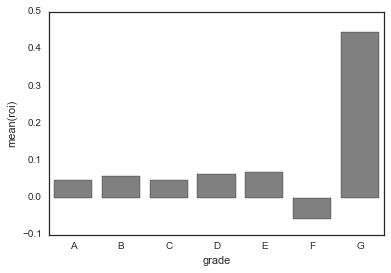

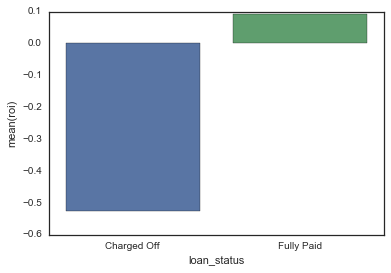

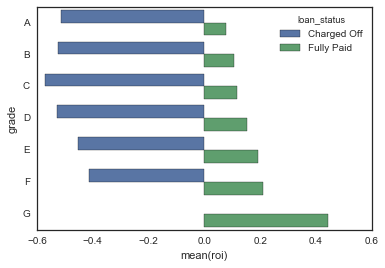

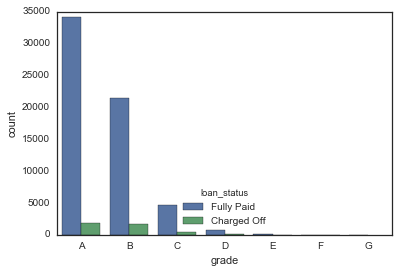

In [424]:
prof_loans['grade'] = prof_loans['grade'].astype('category', ordered=True)
sns.barplot(data=roi.reset_index(), x='grade', y='roi', color='gray')
plt.show()
roi = prof_loans.groupby('loan_status')['roi'].mean()
sns.barplot(data=roi.reset_index(), x='loan_status', y='roi')
plt.show()
roi = prof_loans.groupby(['grade', 'loan_status'])['roi'].mean()
sns.barplot(data=roi.reset_index(), x='roi', y='grade', hue='loan_status', orient='h')
plt.show()
sns.countplot(data=prof_loans, x='grade', hue='loan_status')
plt.show()

In [409]:
prof_loans


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,roi
11,1069908,1305008,12000.0,12000.0,12000.0,36 months,12.69,402.54,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.161923
14,1069057,1303503,10000.0,10000.0,10000.0,36 months,10.65,325.74,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.252801
17,1069971,1304884,3600.0,3600.0,3600.0,36 months,6.03,109.57,A,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.051394
19,1069742,1304855,9200.0,9200.0,9200.0,36 months,6.03,280.01,A,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028257
24,1069559,1304634,6000.0,6000.0,6000.0,36 months,11.71,198.46,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.658310
28,1069799,1304678,4000.0,4000.0,4000.0,36 months,11.71,132.31,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121198
31,1069539,1304608,31825.0,31825.0,31825.0,36 months,7.90,995.82,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096185
33,1069591,1304289,5000.0,5000.0,5000.0,36 months,8.90,158.77,A,A5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142918
36,1069361,1304255,10800.0,10800.0,10800.0,36 months,9.91,348.03,B,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125667
37,1069357,1304251,15000.0,15000.0,15000.0,36 months,7.90,469.36,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.110840


In [393]:
closed_loans.index.tolist()

[1077501,
 1077430,
 1077175,
 1076863,
 1075269,
 1072053,
 1071795,
 1071570,
 1070078,
 1069908,
 1064687,
 1069866,
 1069057,
 1069759,
 1065775,
 1069971,
 1062474,
 1069742,
 1069740,
 1039153,
 1069710,
 1069700,
 1069559,
 1069697,
 1069800,
 1069657,
 1069799,
 1047704,
 1032111,
 1069539,
 1069591,
 1069530,
 1069522,
 1069361,
 1069357,
 1069356,
 1067573,
 1069506,
 1069314,
 1060578,
 1069469,
 1051117,
 1069465,
 1069283,
 1069287,
 1069453,
 1069248,
 1068120,
 1069244,
 1069243,
 1069238,
 1069410,
 1068409,
 1068487,
 1043961,
 1068945,
 1069142,
 1069136,
 1068923,
 1069126,
 1069102,
 1069093,
 1069030,
 1068906,
 1069073,
 1069043,
 1060981,
 1069071,
 1069070,
 1068893,
 1068882,
 1069039,
 1068416,
 1068997,
 1048390,
 1068994,
 1068475,
 1068989,
 1068967,
 1068744,
 1045509,
 1041756,
 1068694,
 1068792,
 1068558,
 1068322,
 1065674,
 1068547,
 1068545,
 1049528,
 1068542,
 1068350,
 1068509,
 1068508,
 1066641,
 1068315,
 1068309,
 1068326,
 1066767,
 1068484,


Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off            0        4241     4241
Fully Paid             0       61055    61055
__all__                0       65296    65296


Overall Statistics:

Accuracy: 0.935049620191
95% CI: (0.93313232985352268, 0.93692813651530282)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                               Charged Off Fully Paid
Population                                  65296      65296
P: Condition positive                        4241      61055
N: Condition negative                       61055       4241
Test outcome positive                           0      65296
Test outcome negative                       65296          0
TP: True Positive                               0      61055
TN: True Negative                           61055          0
FP: False Positive                              0   

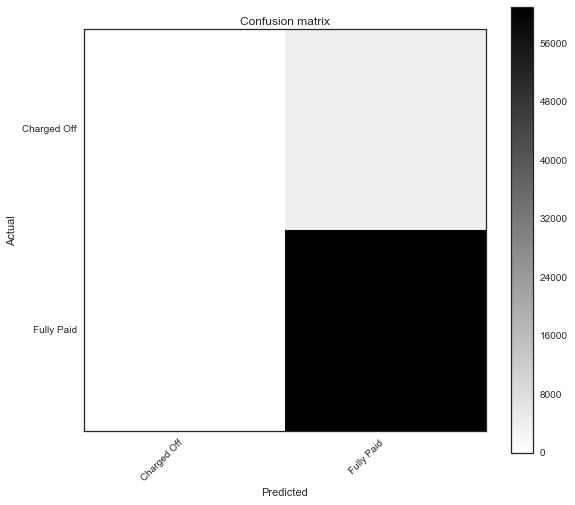

In [388]:
y_score = clf.predict_proba(closed_loans_scaled)
prediction = clf.predict(closed_loans_scaled)
confusion_matrix = ConfusionMatrix(np.array(closed_loans['loan_status'][y_score[:,1] > 0.9]), prediction[y_score[:,1] > 0.9])
confusion_matrix.print_stats()
confusion_matrix.plot()

In [386]:
np.array(closed_loans['loan_status'][y_score[:,1] > 0.9])

array(['Fully Paid', 'Charged Off', 'Fully Paid', ..., 'Fully Paid',
       'Fully Paid', 'Fully Paid'], dtype=object)

In [377]:
prediction[y_score[:,1] > 0.9]

array(['Fully Paid', 'Fully Paid', 'Fully Paid', ..., 'Fully Paid',
       'Fully Paid', 'Fully Paid'], dtype=object)

In [374]:
y_total[y_score[:,1] > 0.9]

225891     Fully Paid
424340    Charged Off
189953     Fully Paid
15805      Fully Paid
31773      Fully Paid
24921      Fully Paid
175902     Fully Paid
616528     Fully Paid
78182      Fully Paid
158031     Fully Paid
98202     Charged Off
16376      Fully Paid
176488     Fully Paid
19866      Fully Paid
206337     Fully Paid
203157     Fully Paid
72040      Fully Paid
344699     Fully Paid
29128      Fully Paid
796292     Fully Paid
23385      Fully Paid
90823     Charged Off
303026     Fully Paid
769678     Fully Paid
24073     Charged Off
170393     Fully Paid
189629     Fully Paid
80527      Fully Paid
185266    Charged Off
1919       Fully Paid
             ...     
186852     Fully Paid
25029      Fully Paid
191388     Fully Paid
138782     Fully Paid
285786     Fully Paid
711329     Fully Paid
414029     Fully Paid
69766      Fully Paid
284884     Fully Paid
304993    Charged Off
864821     Fully Paid
371647     Fully Paid
39221      Fully Paid
218513     Fully Paid
35084     

In [371]:
prediction[y_score[:,1] > 0.9]

array(['Fully Paid', 'Fully Paid', 'Fully Paid', ..., 'Fully Paid',
       'Fully Paid', 'Fully Paid'], dtype=object)

In [414]:
X_total = pd.concat([X_train_scaled, X_test_scaled])
y_total = pd.concat([y_train, y_test])

Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off            0        1082     1082
Fully Paid             0       15023    15023
__all__                0       16105    16105


Overall Statistics:

Accuracy: 0.932815895685
95% CI: (0.92883974791545454, 0.93663484018407073)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                               Charged Off Fully Paid
Population                                  16105      16105
P: Condition positive                        1082      15023
N: Condition negative                       15023       1082
Test outcome positive                           0      16105
Test outcome negative                       16105          0
TP: True Positive                               0      15023
TN: True Negative                           15023          0
FP: False Positive                              0   

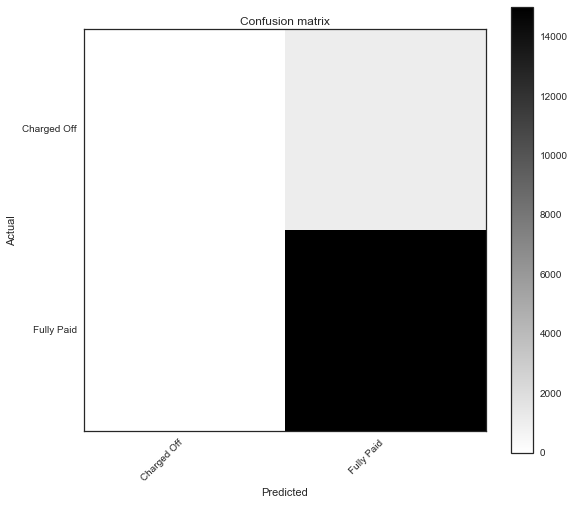

In [415]:
y_score = clf.predict_proba(X_total)
prediction = clf.predict(X_total)
confusion_matrix = ConfusionMatrix(y_total[y_score[:,1] > 0.9], prediction[y_score[:,1] > 0.9])
confusion_matrix.print_stats()
confusion_matrix.plot()

In [416]:
diff_mean = X_total[y_score[:,1] > 0.9].mean() - X_total.mean()
abs(diff_mean).sort_values(ascending=False)

int_rate                        1.029157
sub_grade                       0.942607
grade                           0.925247
annual_inc                      0.608917
revol_util                      0.539280
dti                             0.531208
term                            0.446514
total_acc                       0.251735
home_ownership                  0.236309
inq_last_6mths                  0.227330
days_since_first_credit_line    0.183626
emp_length                      0.114662
loan_amnt                       0.101279
revol_bal                       0.099797
delinq_2yrs                     0.084395
installment                     0.080104
zip_code                        0.068169
pub_rec                         0.066996
addr_state                      0.026992
open_acc                        0.017322
acc_now_delinq                  0.016847
purpose                         0.012195
dtype: float64

In [421]:
for col in X_total.columns:
    result = ttest_ind(X_total[y_score[:,1] > 0.9][col], X_total[col])
    print(col, ':', result)
#X_total[y_score[:,1] > 0.9].mean() - X_total.mean()

term : Ttest_indResult(statistic=-111.1274594789467, pvalue=0.0)
int_rate : Ttest_indResult(statistic=-252.55245382254896, pvalue=0.0)
installment : Ttest_indResult(statistic=-18.291381247594764, pvalue=1.058913389464325e-74)
grade : Ttest_indResult(statistic=-228.05864402831577, pvalue=0.0)
sub_grade : Ttest_indResult(statistic=-232.6328655787587, pvalue=0.0)
emp_length : Ttest_indResult(statistic=26.186558411268546, pvalue=5.4744312026930184e-151)
home_ownership : Ttest_indResult(statistic=54.644952956066348, pvalue=0.0)
annual_inc : Ttest_indResult(statistic=132.54099142904784, pvalue=0.0)
purpose : Ttest_indResult(statistic=-2.8004280871792182, pvalue=0.0051037954727872238)
zip_code : Ttest_indResult(statistic=15.477599274683396, pvalue=5.1433161223269419e-54)
addr_state : Ttest_indResult(statistic=-6.1629362457205694, pvalue=7.1493494476485885e-10)
delinq_2yrs : Ttest_indResult(statistic=-20.014038201633305, pvalue=4.7168489070678436e-89)
inq_last_6mths : Ttest_indResult(statistic

In [418]:
X_total[y_score[:,1] > 0.9]['term']

7       -0.534690
9       -0.534690
10      -0.534690
18      -0.534690
28      -0.534690
29      -0.534690
32      -0.534690
39      -0.534690
51      -0.534690
52      -0.534690
54      -0.534690
56      -0.534690
57      -0.534690
64       1.870241
66      -0.534690
73      -0.534690
74      -0.534690
79      -0.534690
80      -0.534690
87      -0.534690
90      -0.534690
92      -0.534690
109     -0.534690
110     -0.534690
114     -0.534690
127     -0.534690
130     -0.534690
141      1.870241
143     -0.534690
147     -0.534690
           ...   
75737   -0.534690
75738   -0.534690
75741   -0.534690
75743   -0.534690
75745   -0.534690
75760   -0.534690
75765   -0.534690
75768   -0.534690
75769   -0.534690
75773   -0.534690
75779   -0.534690
75781   -0.534690
75782   -0.534690
75785   -0.534690
75786   -0.534690
75789   -0.534690
75790   -0.534690
75793   -0.534690
75796   -0.534690
75798   -0.534690
75802   -0.534690
75804   -0.534690
75806   -0.534690
75815   -0.534690
75821   -0

In [320]:
X_total.mean()

term                            0.000735
int_rate                        0.000869
installment                     0.000411
grade                           0.001088
sub_grade                       0.001040
emp_length                      0.000231
home_ownership                  0.000497
annual_inc                      0.000595
purpose                        -0.000405
zip_code                       -0.000062
addr_state                      0.000371
delinq_2yrs                     0.001245
inq_last_6mths                 -0.000849
open_acc                       -0.001960
pub_rec                        -0.000001
revol_bal                       0.001173
revol_util                      0.001154
total_acc                      -0.002846
acc_now_delinq                 -0.000471
loan_amnt                       0.000421
dti                            -0.000668
days_since_first_credit_line   -0.000040
dtype: float64

In [309]:
X_total #most interesting features: 'int_rate', 'annual_inc', 'sub_grade', 'term', 'dti'
# vergelijken predicted > 0.9 vs. all?

,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,purpose,zip_code,...,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,loan_amnt,dti,days_since_first_credit_line
0,-0.534690,-0.401743,1.005720,-0.595481,-0.601032,-1.503256,-1.055764,0.437807,0.538410,1.171976,...,-0.800122,1.851360,-0.329101,0.556035,0.407422,1.183897,-0.051363,0.792242,1.453198,-0.058769
1,1.870241,0.865487,0.347860,0.900654,0.988284,-1.503256,0.528760,0.519080,0.538410,-0.778588,...,-0.800122,1.442024,-0.329101,1.029208,0.592675,1.353932,-0.051363,0.792242,0.796525,-0.262228
2,-0.534690,-0.092884,-0.352335,0.152587,0.080104,0.643787,-1.055764,0.681624,0.288887,-0.894062,...,3.886942,-0.809321,-0.329101,-0.174204,0.834310,-0.091366,-0.051363,-0.462926,0.648741,-0.071656
3,1.870241,0.554357,-0.710339,0.152587,0.231467,-1.503256,-1.055764,-0.781278,0.288887,-1.324746,...,0.137291,3.693369,-0.329101,-0.510631,-0.095984,1.013862,-0.051363,-0.438315,-0.115878,-1.152993
4,-0.534690,0.863216,-0.427319,0.900654,0.761239,-0.698114,-1.055764,-0.510370,0.538410,1.171976,...,0.137291,0.828021,-0.329101,-0.525372,-0.595362,0.588774,-0.051363,-0.595211,0.043471,-0.403985
5,1.870241,0.574796,0.291632,0.152587,0.231467,-1.503256,-1.055764,0.275262,0.538410,0.023484,...,0.137291,0.214017,-0.329101,-0.374646,-0.325537,2.204107,-0.051363,0.792242,0.057607,-0.368838
6,1.870241,0.910907,-0.056320,0.900654,0.761239,1.180548,-1.055764,-0.618734,0.538410,-1.418373,...,0.137291,-0.809321,1.963812,-0.152393,0.274523,-0.601471,-0.051363,0.300019,-1.060407,-0.047835
7,-0.534690,-1.103488,-1.059640,-1.343549,-1.206485,-0.698114,-1.055764,-0.700006,0.538410,-1.312263,...,-0.800122,-0.604654,-0.329101,-0.534129,-0.196665,-0.006348,-0.051363,-1.053594,-1.310997,-1.176814
8,-0.534690,0.463516,0.798665,0.152587,0.155785,1.180548,0.528760,-0.158190,0.288887,0.248189,...,0.137291,-0.195318,-0.329101,0.499356,1.261198,-0.261401,-0.051363,0.484603,-0.086321,-0.416872
9,-0.534690,-1.103488,1.535473,-1.343549,-1.206485,1.180548,0.528760,0.789987,0.538410,1.421648,...,-0.800122,0.418685,-0.329101,0.841766,-0.168474,0.673792,-0.051363,1.407521,-0.637618,0.451244


In [40]:
sum(y_score[:,1] > 0.5) / len(y_score[:,1] )

0.014716617133322906

In [41]:
max(y_score[~prediction, 1])

0.49995529304248365

In [74]:
diff_thres = y_score[:,1] > 0.18

0.686387709202
Confusion Matrix:

Predicted  False  True  __all__
Actual                         
False       8290  5751    14041
True        1677  1168     2845
__all__     9967  6919    16886


Overall Statistics:

Accuracy: 0.560108966007
95% CI: (0.55258278403993444, 0.56761443612344797)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.000610218839777
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                      False        True 
Population                                   16886        16886
P: Condition positive                        14041         2845
N: Condition negative                         2845        14041
Test outcome positive                         9967         6919
Test outcome negative                         6919         9967
TP: True Positive                             8290         1168
TN: True Negative                             1168         8290
FP: False Positive                            1677         5751
FN: F

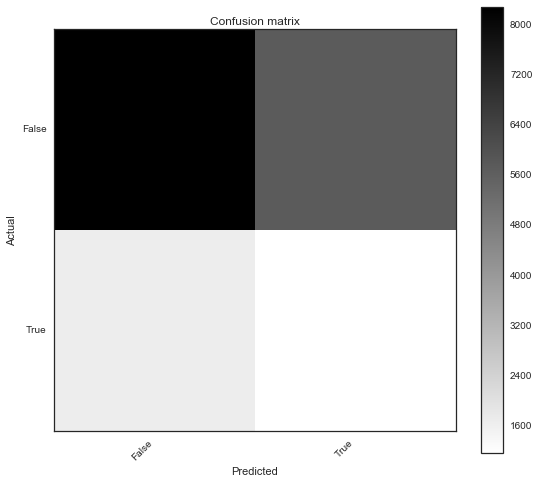

In [79]:
print(f1_score(y_test, diff_thres, average='weighted'))
confusion_matrix = ConfusionMatrix(y_test, diff_thres)
confusion_matrix.print_stats()
confusion_matrix.plot()

#### Random Forest

Also with the random forest algorithm for both only grade and all features we find the same accuracy measurements as measured with cross-validation on the training set. Therefore the logistic regression algorithm with all features still performance the best, although it performs not very well. 

0.739008115086
Predicted  False  True  __all__
Actual                         
False      14041     0    14041
True        2845     0     2845
__all__    16886     0    16886


/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


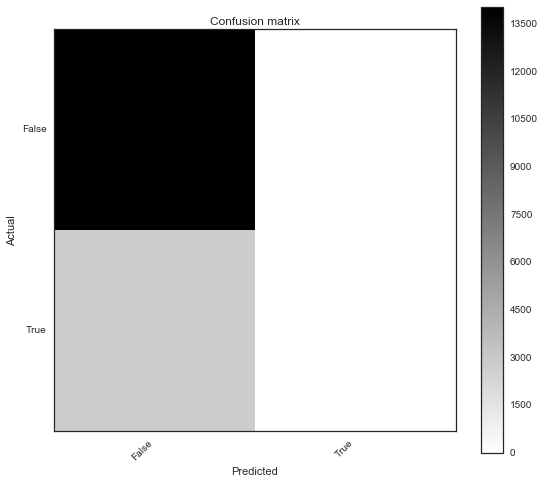

In [46]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train.loc[:,['grade']], y_train)
prediction = clf.predict(X_test.loc[:,['grade']])
print(f1_score(y_test, prediction, average='weighted'))
confusion_matrix = ConfusionMatrix(y_test, prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.5


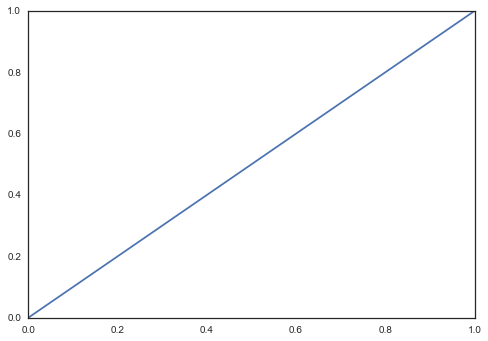

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, prediction, pos_label=True)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

0.749727275393
Predicted  False  True  __all__
Actual                         
False      13865   176    14041
True        2806    39     2845
__all__    16671   215    16886


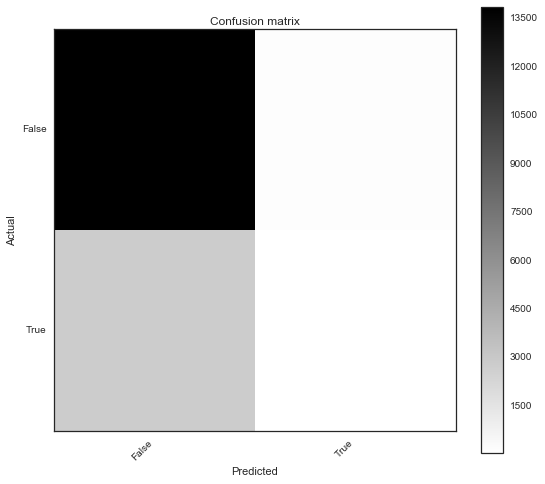

In [48]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(f1_score(y_test, prediction, average='weighted'))
confusion_matrix = ConfusionMatrix(y_test, prediction)
print(confusion_matrix)
confusion_matrix.plot()

[False  True]
0.694945786794


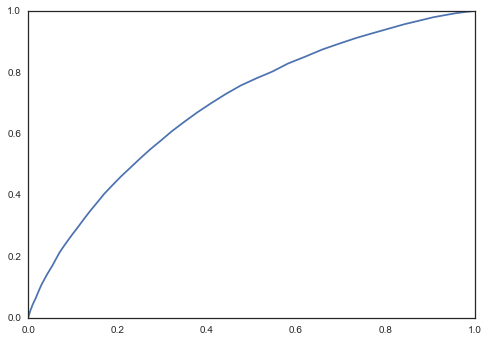

In [49]:
y_score = clf.predict_proba(X_test)
print(clf.classes_)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1], pos_label=True)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

### Predict grade

In [50]:
X_train, X_test, y_train, y_test = train_test_split(closed_loans.iloc[:, 0:24], 
                                                    closed_loans['grade'], test_size=0.3, 
                                                    random_state=123, stratify=closed_loans['loan_status'])
X_train = X_train.drop(['grade', 'sub_grade', 'int_rate'], axis=1)
X_test = X_test.drop(['grade', 'sub_grade', 'int_rate'], axis=1)

In [51]:
# features that are not float or int, so not to be converted:

# date:
# earliest_cr_line

# ordered:
# emp_length, zip_code, term

# unordered:
# home_ownership, purpose, addr_state (ordered geographically)

# date
X_train['earliest_cr_line'] = pd.to_datetime(X_train['earliest_cr_line']).dt.strftime("%s")
X_train['earliest_cr_line'] = [0 if date=='NaT' else int(date) for date in X_train['earliest_cr_line']]

# term
X_train['term'] = X_train['term'].apply(lambda x: int(x.split(' ')[1]))

# emp_length
emp_length_dict = {'n/a':0,
                   '< 1 year':0,
                   '1 year':1,
                   '2 years':2,
                   '3 years':3,
                   '4 years':4,
                   '5 years':5,
                   '6 years':6,
                   '7 years':7,
                   '8 years':8,
                   '9 years':9,
                   '10+ years':10}
X_train['emp_length'] = X_train['emp_length'].apply(lambda x: emp_length_dict[x])

# zipcode
X_train['zip_code'] = X_train['zip_code'].apply(lambda x: int(x[0:3]))

# house
house_dict = {'NONE': 0, 'OTHER': 0, 'ANY': 0, 'RENT': 1, 'MORTGAGE': 2, 'OWN': 3}
X_train['home_ownership'] = X_train['home_ownership'].apply(lambda x: house_dict[x])

# purpose
purpose_dict = {'other': 0, 'small_business': 1, 'renewable_energy': 2, 'home_improvement': 3,
                'house': 4, 'educational': 5, 'medical': 6, 'moving': 7, 'car': 8, 
                'major_purchase': 9, 'wedding': 10, 'vacation': 11, 'credit_card': 12, 
                'debt_consolidation': 13}
X_train['purpose'] = X_train['purpose'].apply(lambda x: purpose_dict[x])

# states
state_dict = {'AK': 0, 'WA': 1, 'ID': 2, 'MT': 3, 'ND': 4, 'MN': 5, 
              'OR': 6, 'WY': 7, 'SD': 8, 'WI': 9, 'MI': 10, 'NY': 11, 
              'VT': 12, 'NH': 13, 'MA': 14, 'CT': 15, 'RI': 16, 'ME': 17,
              'CA': 18, 'NV': 19, 'UT': 20, 'CO': 21, 'NE': 22, 'IA': 23, 
              'KS': 24, 'MO': 25, 'IL': 26, 'IN': 27, 'OH': 28, 'PA': 29, 
              'NJ': 30, 'KY': 31, 'WV': 32, 'VA': 33, 'DC': 34, 'MD': 35, 
              'DE': 36, 'AZ': 37, 'NM': 38, 'OK': 39, 'AR': 40, 'TN': 41, 
              'NC': 42, 'TX': 43, 'LA': 44, 'MS': 45, 'AL': 46, 'GA': 47, 
              'SC': 48, 'FL': 49, 'HI': 50}
X_train['addr_state'] = X_train['addr_state'].apply(lambda x: state_dict[x])

# make NA's, inf and -inf 0
X_train = X_train.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)


# date
X_test['earliest_cr_line'] = pd.to_datetime(X_test['earliest_cr_line']).dt.strftime("%s")
X_test['earliest_cr_line'] = [0 if date=='NaT' else int(date) for date in X_test['earliest_cr_line']]

# term
X_test['term'] = X_test['term'].apply(lambda x: int(x.split(' ')[1]))

# emp_length
X_test['emp_length'] = X_test['emp_length'].apply(lambda x: emp_length_dict[x])

# zipcode
X_test['zip_code'] = X_test['zip_code'].apply(lambda x: int(x[0:3]))

# house
X_test['home_ownership'] = X_test['home_ownership'].apply(lambda x: house_dict[x])

# purpose
X_test['purpose'] = X_test['purpose'].apply(lambda x: purpose_dict[x])

# states
X_test['addr_state'] = X_test['addr_state'].apply(lambda x: state_dict[x])

# make NA's, inf and -inf 0
X_test = X_test.fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0)

In [52]:
from sklearn import preprocessing
X_train_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Confusion Matrix:

Predicted      A   B    C     D    E  F  G  __all__
Actual                                             
A          12769  17    2     0    0  0  0    12788
B          22809  25   21     7    0  0  0    22862
C          19651  31   53    37    0  0  0    19772
D          12102   1   49   101    2  0  0    12255
E           5636   0   22   282   14  5  2     5961
F           1904   0    6   379  114  3  1     2407
G            370   0    9   201   91  0  0      671
__all__    75241  74  162  1007  221  8  3    76716


Overall Statistics:

Accuracy: 0.16899994786
95% CI: (0.16635413333328417, 0.17167081891471681)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0028273004168
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                         A            B            C  \
Population                                  76716        76716        76716   
P: Condition positive                       12788        22862        19772   
N:

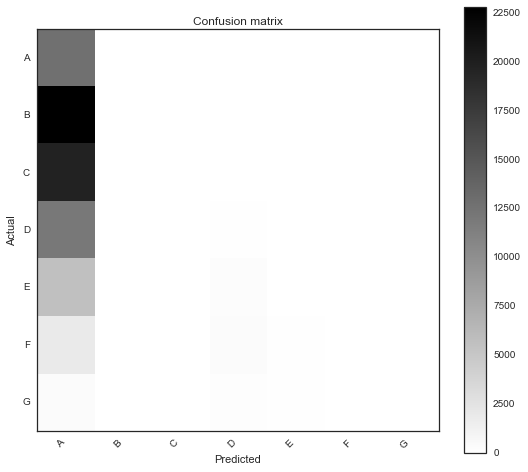

In [53]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

lb = LabelBinarizer()
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
lb.fit(grades)
y_train_2 = lb.transform(y_train)

clf = OneVsRestClassifier(LogisticRegression(penalty='l1'))
predict_y = clf.fit(X_train_scaled, y_train_2).predict(X_test_scaled)
predict_y = lb.inverse_transform(predict_y)

#print(accuracy_score(y_test, predict_y))
confusion_matrix = ConfusionMatrix(np.array(y_test, dtype='<U1'), predict_y)
confusion_matrix.plot()
confusion_matrix.print_stats()

# find index of top 5 highest coefficients, aka most used features for prediction
coefs = clf.coef_
positions = abs(coefs[0]).argsort()[-5:][::-1]
print(X_train_scaled.columns[positions])
print(coefs[0][positions])

0.388171958913
Predicted      A      B     C    D    E    F   G  __all__
Actual                                                   
A          12253    531     4    0    0    0   0    12788
B          11097  11321   438    6    0    0   0    22862
C          14119   1160  4422   70    1    0   0    19772
D          10933     26   624  604   68    0   0    12255
E           4958      0    29  141  802   31   0     5961
F           1991      0     6   10   70  330   0     2407
G            541      0     0    3    8   72  47      671
__all__    55892  13038  5523  834  949  433  47    76716


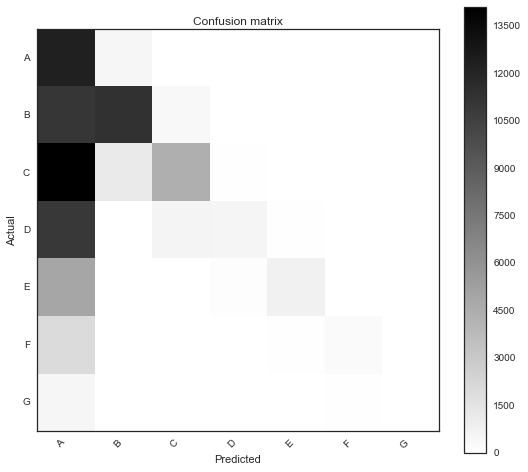

In [54]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
predict_y = clf.fit(X_train_scaled, y_train_2).predict(X_test_scaled)
predict_y = lb.inverse_transform(predict_y)

print(accuracy_score(y_test, predict_y))
confusion_matrix = ConfusionMatrix(np.array(y_test, dtype='<U1'), predict_y)
confusion_matrix.plot()
print(confusion_matrix)

In [55]:
confusion_matrix.print_stats()

Confusion Matrix:

Predicted      A      B     C    D    E    F   G  __all__
Actual                                                   
A          12253    531     4    0    0    0   0    12788
B          11097  11321   438    6    0    0   0    22862
C          14119   1160  4422   70    1    0   0    19772
D          10933     26   624  604   68    0   0    12255
E           4958      0    29  141  802   31   0     5961
F           1991      0     6   10   70  330   0     2407
G            541      0     0    3    8   72  47      671
__all__    55892  13038  5523  834  949  433  47    76716


Overall Statistics:

Accuracy: 0.388171958913
95% CI: (0.38472121084297828, 0.39163116596403957)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.241353230121
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        A          B          C  \
Population                                 76716      76716      76716   
P: Condition positive          

In [56]:
features = []
for i,j in enumerate(grades):
    print('\n',j)
    feat_imp = clf.estimators_[i].feature_importances_
    positions = abs(feat_imp).argsort()[-5:][::-1]
    features.extend(list(X_train.columns[positions]))
    print(X_train.columns[positions])
    print(feat_imp[positions])


 A
Index(['revol_util', 'installment', 'revol_bal', 'funded_amnt_inv',
       'earliest_cr_line'],
      dtype='object')
[ 0.16382844  0.11410527  0.06305903  0.05875622  0.05705625]

 B
Index(['installment', 'revol_util', 'funded_amnt_inv', 'revol_bal', 'dti'], dtype='object')
[ 0.18082548  0.0815748   0.06421254  0.06384274  0.06121603]

 C
Index(['installment', 'revol_util', 'revol_bal', 'dti', 'earliest_cr_line'], dtype='object')
[ 0.15151168  0.08249654  0.07178606  0.07000384  0.06760838]

 D
Index(['installment', 'revol_util', 'revol_bal', 'dti', 'earliest_cr_line'], dtype='object')
[ 0.12177678  0.08687976  0.0728564   0.07252917  0.069689  ]

 E
Index(['installment', 'revol_util', 'funded_amnt_inv', 'dti', 'revol_bal'], dtype='object')
[ 0.16401471  0.07213717  0.06327645  0.06278267  0.06117716]

 F
Index(['installment', 'funded_amnt_inv', 'revol_util', 'funded_amnt',
       'loan_amnt'],
      dtype='object')
[ 0.19441472  0.06760932  0.06559835  0.06320743  0.06153764]

 G

In [57]:
pd.Series(features).value_counts()

installment         7
revol_util          7
revol_bal           5
dti                 5
funded_amnt_inv     5
earliest_cr_line    3
loan_amnt           2
funded_amnt         1
dtype: int64